### Importing Libraries

In [1]:
import codecs
import glob
import os
import re
from nltk.corpus import stopwords 
import nltk
import gensim.models.word2vec as w2v2
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gensim.models.word2vec as w2v
from matplotlib import rcParams
%pylab inline
warnings.filterwarnings("ignore")

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


### Reading Data

In [2]:
# Reading data into a corpus from 16 different twitter accounts

Health_tweets= sorted(glob.glob("Health-News-Tweets/Health-Tweets/*.txt"))
tweet = u""
for i in Health_tweets:
    print("Reading '{0}'...".format(i))
    with codecs.open(i, "r",encoding="utf8", errors='ignore') as book_file:
        tweet += book_file.read()
    print("Corpus is now {0} characters long".format(len(tweet)))
    print()

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\KaiserHealthNews.txt'...
Corpus is now 553895 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\NBChealth.txt'...
Corpus is now 1110322 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\bbchealth.txt'...
Corpus is now 1543004 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\cbchealth.txt'...
Corpus is now 2222014 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\cnnhealth.txt'...
Corpus is now 2874222 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\everydayhealth.txt'...
Corpus is now 3342790 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\foxnewshealth.txt'...
Corpus is now 3605028 characters long

Reading 'G:/UIUC/Assignments/MLTP/Health-News-Tweets/Health-Tweets\gdnhealthcare.txt'...
Corpus is now 4150217 charac

### Data Cleaning

In [3]:
#Tokenizing the corpus

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(tweet)

In [4]:
#Before Cleaning the Data

print("Number of Tweets:",len(raw_sentences))
print(raw_sentences[4])

Number of Tweets: 27208
http://khne.ws/1NaiTex #Obamacare http://pbs.twimg.com/media/CCF1kY-UMAAG1EX.jpg
585878346556289024|Wed Apr 08 18:54:17 +0000 2015|Still getting your taxes done?


In [5]:
#Cleaning the tweets just to fetch important information

raw_sentences_main=[]
stop_words = set(stopwords.words('english')) 
for i in raw_sentences:
    
    #removing hyperlinks from tweets
    a=re.sub(r'http\S+', '', i)
    
    #removing Timestamp and ID from the tweets
    b=a[a.rfind('|')+1:]
    c=b[b.rfind('|')+1:]
    
    #removing special characters from tweets
    d=re.sub(r'\W', ' ', c)
    
    #Converting tweets into lowercase
    e=d.lower()
    
    #Removing Stop-words
    text = ' '.join([word for word in e.split() if word not in stop_words])
    
    #appending the cleaned tweets into a list
    raw_sentences_main.append(text)

In [6]:
#Data after cleaning

print(raw_sentences_main[4])

still getting taxes done


### Tokenizing the tweets

In [7]:
wpt = nltk.WordPunctTokenizer()
sentences = [wpt.tokenize(document) for document in raw_sentences_main]

#Data after tokenizing
print(sentences[4])

['still', 'getting', 'taxes', 'done']


### Building a Word2Vec model

In [8]:
#Model Parameters

num_features = 300
min_word_count = 3
context_size = 7
seed = 1
Healthvec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
)

In [9]:
#Building Vocab using the tweets

Healthvec.build_vocab(sentences)
print("Word2Vec vocabulary length:", len(Healthvec.wv.vocab))

Word2Vec vocabulary length: 6614


In [10]:
#Training the model for 5 epochs

Healthvec.train(sentences,total_examples=Healthvec.corpus_count,epochs=5)

(632734, 738840)

### Reducing dimensions to a 2-D space with T-SNE

In [11]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = Healthvec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [12]:
# Creating a Dataframe with Words and 
Words_2D_Space = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[Healthvec.wv.vocab[word].index])
            for word in Healthvec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [13]:
Words_2D_Space.head(20)

,word,x,y
0,new,-61.455757,45.674976
1,sort,-28.294548,32.397400
2,activity,6.226508,49.038692
3,seeing,-25.533316,41.643372
4,patients,-70.434929,28.261862
5,montana,65.551430,-34.667812
6,expand,-53.903667,41.607437
7,medicaid,-62.115482,26.531446
8,program,-21.239790,56.253143
9,rt,-67.398575,30.710287


### Visulaization in 2D Space

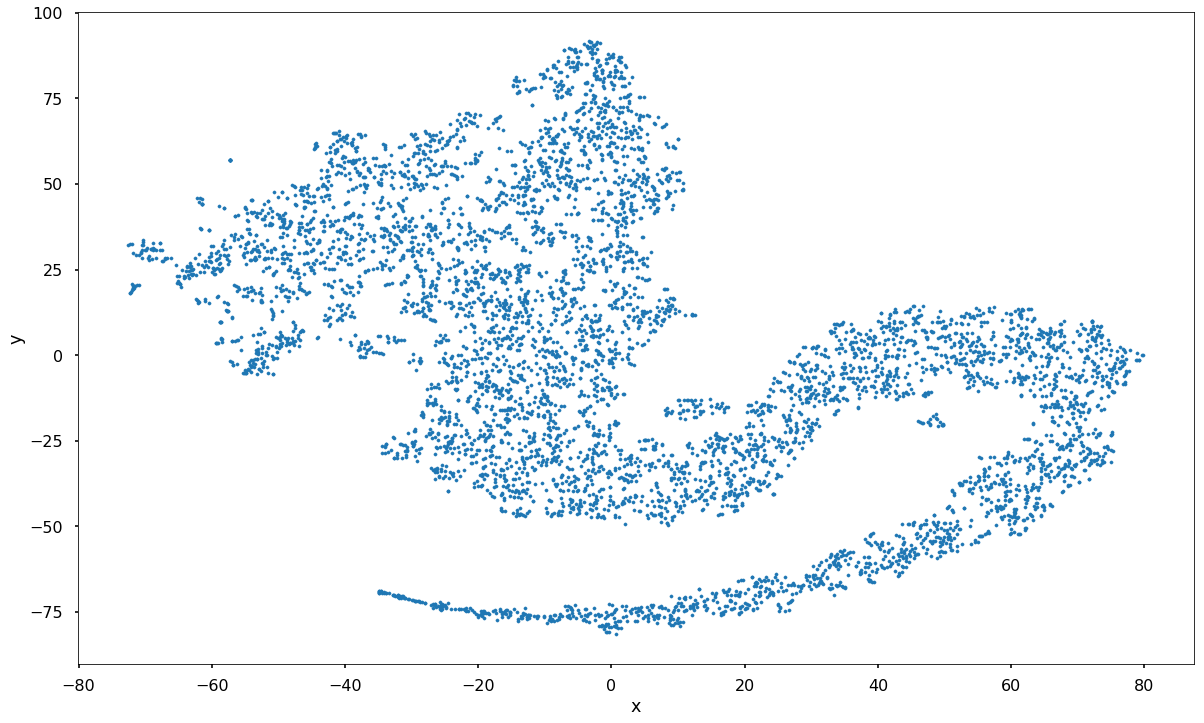

In [14]:
sns.set_context("poster")
Words_2D_Space.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [15]:
#Function for taking a closer look

def plot_region(x_bounds, y_bounds):
    slice = Words_2D_Space[
        (x_bounds[0] <= Words_2D_Space.x) &
        (Words_2D_Space.x <= x_bounds[1]) & 
        (y_bounds[0] <= Words_2D_Space.y) &
        (Words_2D_Space.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

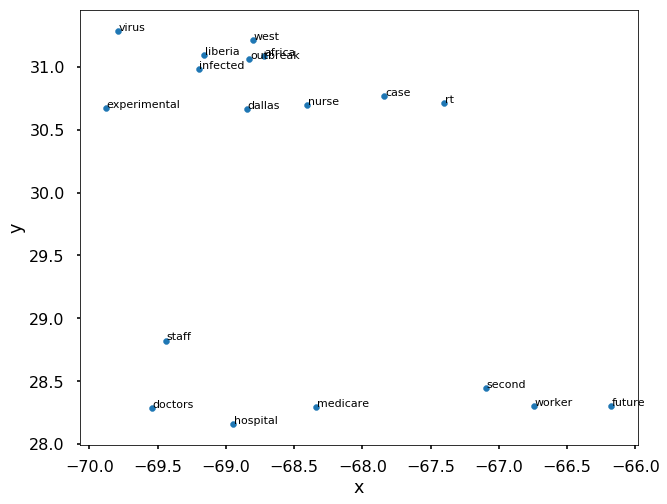

In [18]:
# Words close to "patient"
plot_region(x_bounds=(-70, -65), y_bounds=(28, 32))

### Finding Most Similar Words

In [19]:
def similar_words(word):
    x=[]
    y=[]
    words=Healthvec.most_similar(word)
    for i in range(len(words)):
        x.append(words[i][0])
        y.append(words[i][1])
    rcParams['figure.figsize'] = 8,5
    sns.set_context("poster")
    sns.barplot(x,y,palette="Blues_d")
    sns.set_context("poster")
    plt.xticks(rotation=45)
    plt.xlabel("Similar Words")
    plt.ylabel("Score")
    plt.title('Most Similar Words to %s' %word.upper())

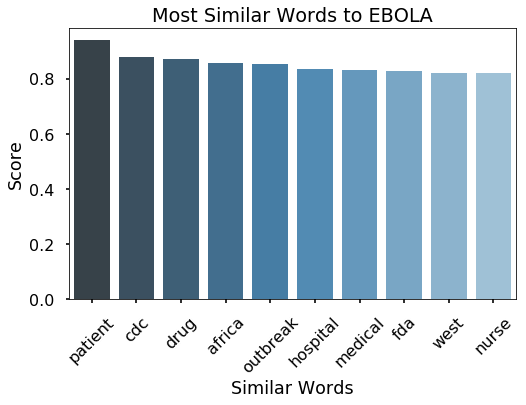

In [20]:
similar_words("ebola")

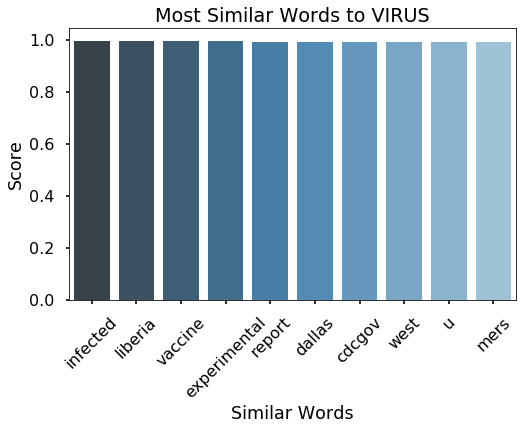

In [21]:
similar_words("virus")

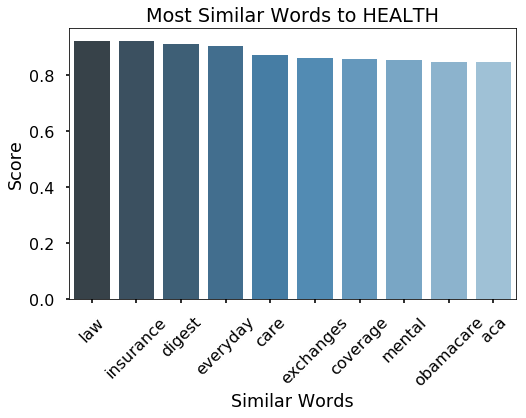

In [22]:
similar_words("health")

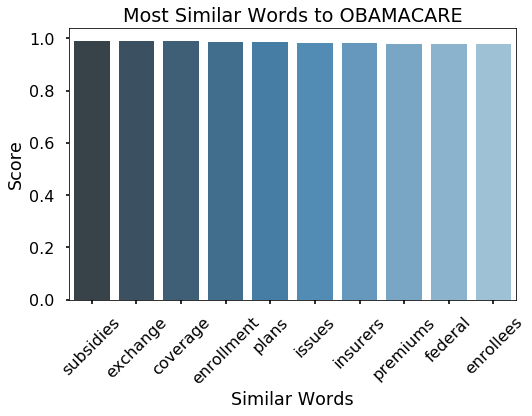

In [23]:
similar_words("obamacare")